# predictive uncertainty analysis

In [7]:
# import packages
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [8]:
from matplotlib.ticker import FuncFormatter 
import matplotlib.ticker as mtick
mpl.rcParams['font.size'] = 16
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 20

In [9]:
# import the annual loads
file_date = '20220118'
fpath = f'../../output/work_run_{file_date}/'
fn = '126001A.26.obs.csv'
fn_meas = '126001A.base.obs.csv'
log_load = True

In [10]:
df = pd.read_csv(fpath + fn, index_col = 'real_name')
# select results of which the pbias is with 15%
# df = df[(df.din_pbias < 15) & (df.din_pbias > -15)]
df_meas = pd.read_csv(fpath + fn_meas, index_col = 'real_name')
if log_load:
    df_meas.loc[:, 'din_2009':] = 10**(df_meas.loc[:, 'din_2009':])
    df.loc[:, 'din_2009':] = 10**(df.loc[:, 'din_2009':])
df['average'] = df.loc[:, 'din_2009':'din_2017'].mean(axis=1).values
df_meas['average'] = df_meas.loc[:, 'din_2009':'din_2017'].mean(axis=1).values

# obs data
obs_annual = [52.093, 99.478, 44.064, 57.936, 53.449, 21.858, 38.561, 51.843, 14.176]
obs_annual.append(np.round(np.mean(obs_annual), 2))
obs_df = pd.DataFrame(data=obs_annual, index = [*np.arange(2009, 2018), 'average'], columns=['Annual loads'])

In [11]:
# reorganize the dataframe for plotting
df_plot = pd.DataFrame(data = df.values[:, 1:].T.flatten(), columns=['Annual loads'])
year_col = np.repeat(np.arange(2009, 2019), df.shape[0], 0).T
df_plot['year'] = year_col
df_plot['type'] = 'Estimate'

df_meas_plot = pd.DataFrame(data = df_meas.values[:, 1:].T.flatten(), columns=['Annual loads'])
year_col = np.repeat(np.arange(2009, 2019), df_meas.shape[0], 0).T
df_meas_plot['year'] = year_col
df_meas_plot['type'] = 'Measurement realization'
df_plot = pd.concat([df_meas_plot, df_plot])

df_plot.reset_index().tail()

,index,Annual loads,year,type
1925,925,61.297703,2018,Estimate
1926,926,58.993120,2018,Estimate
1927,927,61.952209,2018,Estimate
1928,928,51.913722,2018,Estimate
1929,929,63.338739,2018,Estimate


Text(0, 0.5, 'Annual loads(KG)')

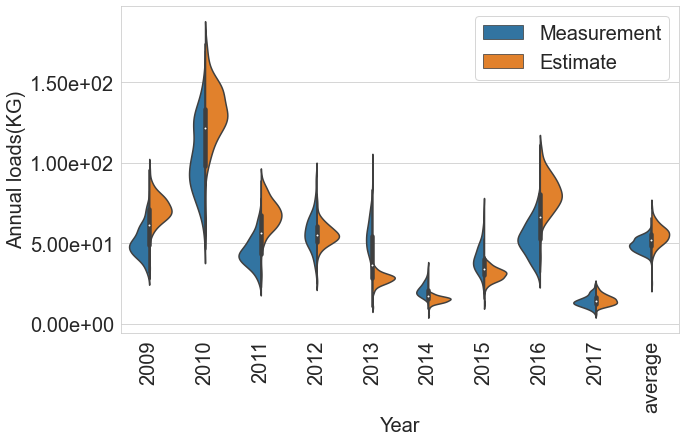

In [12]:
# Plot the uncertainty of annual loads
sns.set_style('whitegrid')
fig = plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='year', y='Annual loads', data=df_plot, hue='type', split=True);
ax.legend(handles=ax.legend_.legendHandles, labels=['Measurement', 'Estimate'])
# obs_df.plot(y=[0], linewidth=0, ax=ax, marker='d', markersize=5, color='r', legend=['Obs']);
ax.set_xticklabels([*np.arange(2009, 2018), 'average'], rotation=90);
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax.set_xlabel('Year')
ax.set_ylabel('Annual loads(KG)')
# plt.savefig(f'../../output/figs/predict_uncertainty_{file_date}.png', dpi=300, format='png')

Text(0, 0.5, 'Annual loads(KG)')

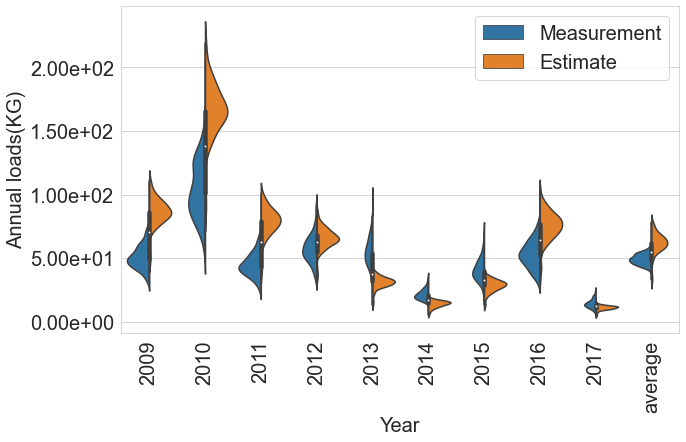

In [6]:
# Plot the uncertainty of annual loads
sns.set_style('whitegrid')
fig = plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='year', y='Annual loads', data=df_plot, hue='type', split=True);
ax.legend(handles=ax.legend_.legendHandles, labels=['Measurement', 'Estimate'])
# obs_df.plot(y=[0], linewidth=0, ax=ax, marker='d', markersize=5, color='r', legend=['Obs']);
ax.set_xticklabels([*np.arange(2009, 2018), 'average'], rotation=90);
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax.set_xlabel('Year')
ax.set_ylabel('Annual loads(KG)')
# plt.savefig(f'../../output/figs/predict_uncertainty_{file_date}.png', dpi=300, format='png')

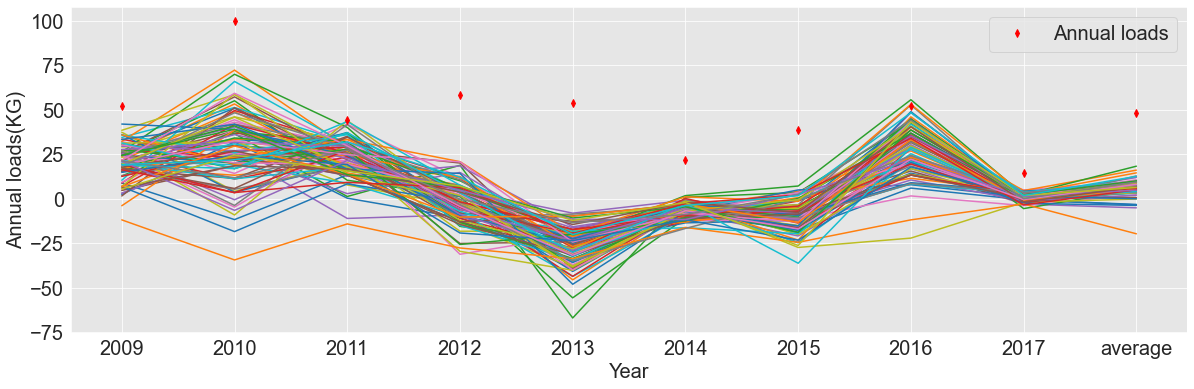

In [15]:
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
df_temp = df - df_meas
ax = df_temp.loc[:, 'din_2009':].T.plot(legend=False, figsize=(20, 6), use_index=True, xlabel='Year', ylabel='Annual loads(KG)')
ax.set_xticks(range(len(df.columns[1:])))
obs_df.plot(y=[0], linewidth=0, ax=ax, marker='d', markersize=5, color='r', legend=['Obs']);
ax.set_xticklabels([*np.arange(2009, 2018), 'average']);
# plt.savefig(f'../../output/figs/predict_uncertainty_lineplot_{file_date}.png', dpi=300, format='png')